## Random Walk Chain

# 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, beta, binom,uniform 
import random 
from tabulate import tabulate

# 1.

# a)

In [2]:
n = 200
nitr = 10000
delta = 0.7
mu = [0,7,10,15]
sigma = [0.01, 0.5, 1]

#Sample N random uniforms U
U = uniform.rvs(0, 1, size=n)

#Variable to store the samples from the mixture distribution                                             
rs = np.zeros(n)
rs[U<=0.3] = norm.rvs(10,0.5,size=len(rs[U<=0.3]))
rs[U>0.3] = norm.rvs(7,0.5,size=len(rs[U>0.3]))

### Plot

Text(0, 0.5, 'Density')

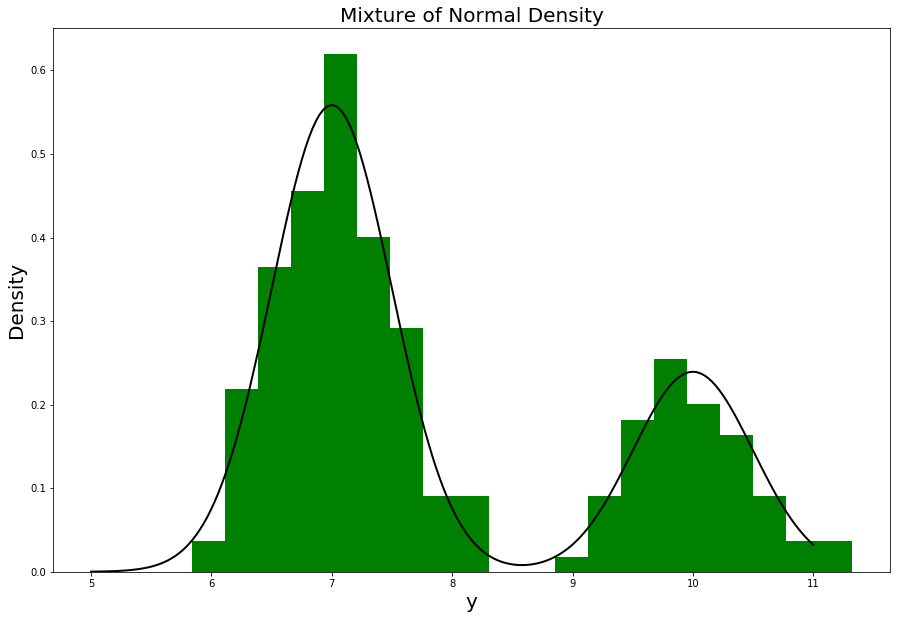

In [3]:
x = np.linspace(5,11,n)
plt.figure(figsize=(15,10))
y = delta*norm.pdf(x,mu[1],sigma[1]) +(1-delta)*norm.pdf(x,mu[2],sigma[1])
plt.hist(rs,20,density=True, color='g')
plt.plot(x, y, 'k-', linewidth=2)
plt.title('Mixture of Normal Density',fontsize=20)
plt.xlabel('y',fontsize=20)
plt.ylabel('Density',fontsize=20)

# b)

### Independance Chain

In [4]:
def f(x):
    f = np.prod(x*norm.pdf(rs,7,0.5) +(1-x)*norm.pdf(rs,10,0.5))
    return f

In [5]:
def R(xt,x):
    return f(x)*uniform.pdf(xt)/(f(xt)*uniform.pdf(x))

In [6]:
v = np.zeros(nitr)
v[0] = uniform.rvs(0, 1, size=1)
for i in range (0,nitr-1):
    xt = v[i]
    x = uniform.rvs(0, 1, size=1)
    p = min(R(xt,x),1)
    d = binom.rvs(1, p, size=1)
    v[i+1] = x*d + xt*(1-d)

### Estimated $\delta$

In [7]:
np.mean(v)

0.7018251648471895

### Estimated std

In [8]:
np.std(v)

0.03134832478930472

### Plot

Text(0, 0.5, 'δ')

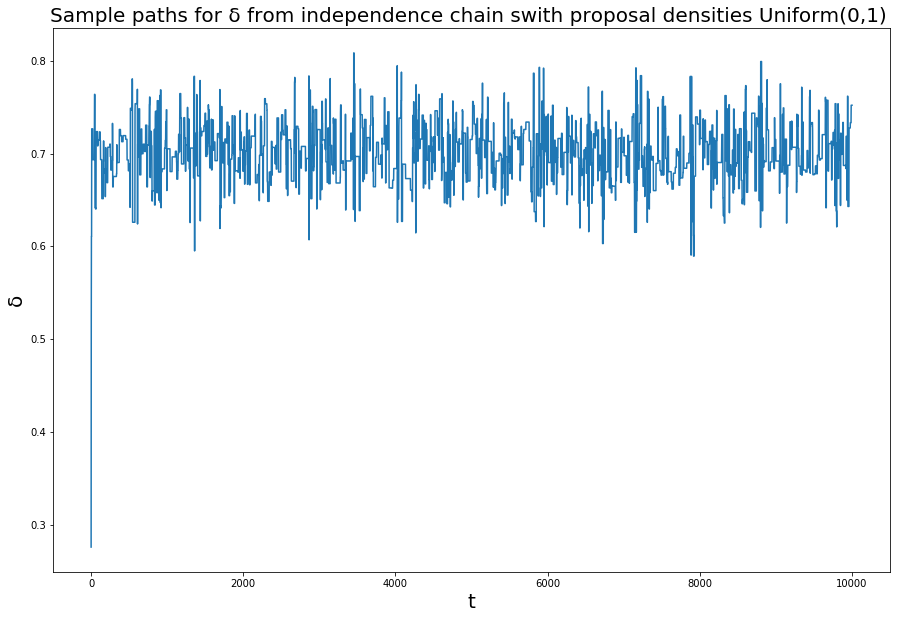

In [9]:
plt.figure(figsize=(15,10))
x = np.linspace(0,nitr,nitr)
plt.plot(x,v)
plt.title('Sample paths for δ from independence chain swith proposal densities Uniform(0,1) ',fontsize=20)
plt.xlabel('t',fontsize=20)
plt.ylabel('δ',fontsize=20)

# C)

### Simple Random Walk Chain

In [10]:
xt_chain = np.zeros(nitr)
for i in range (1,nitr-1):
    eps = np.random.uniform(-1, 1, 1)
    xs = xt_chain[i-1] + eps
    if (xs < 0) | (xs > 1):
        xt_chain[i] = xt_chain[i-1]
    ratio = min(f(xs)/f(xt_chain[i-1]), 1)
    u = np.random.uniform(0, 1, 1)
    if u <= ratio:
        xt_chain[i] = xs
    else:
        xt_chain[i] = xt_chain[i-1]

C:\ProgramData\anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


### Estimated $\delta$

In [11]:
np.mean(xt_chain)

0.7032249998911893

### Estimated std

In [12]:
np.std(xt_chain)

0.033419708205718955

### Plot

Text(0, 0.5, 'δ')

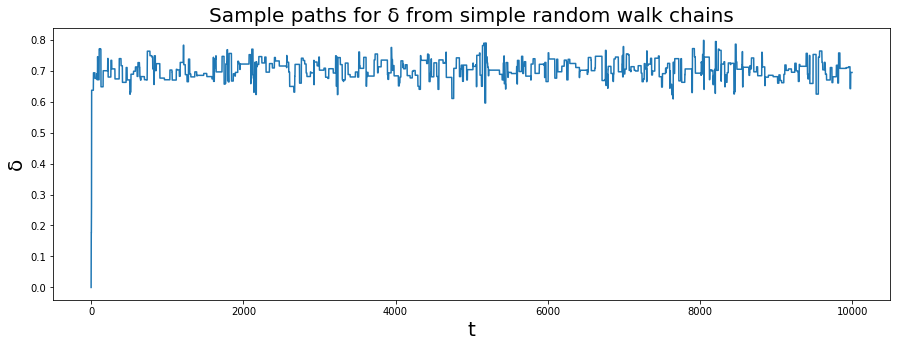

In [13]:
plt.figure(figsize=(15,5))
plt.plot(x[0:nitr-2],xt_chain[0:nitr-2])
plt.title('Sample paths for δ from simple random walk chains',fontsize=20)
plt.xlabel('t',fontsize=20)
plt.ylabel('δ',fontsize=20)

# d)

### Reparameterized Random Walkl Chain

In [14]:
u = np.random.uniform(-1, 1,nitr)
p = np.zeros(nitr)
p[0] = np.exp(u[0])/(1+np.exp(u[0]))

In [15]:
for i in range (0,nitr-1):
    u[i+1] = u[i]+np.random.uniform(-1, 1,1)
    p[i+1] = np.exp(u[i+1])/(1+np.exp(u[i+1]))
    R = np.exp(np.log(f(p[i+1]))-np.log(f(p[i])))*np.exp(u[i])/np.exp(u[i+1])
    if (R<1):
        if(binom.rvs(1, R, size=1)==0):
            p[i+1] = p[i]
            u[i+1] = u[i]

### Estimated $\delta$

In [16]:
np.mean(p)

0.6985072748260698

### Estimated std

In [17]:
np.std(p)

0.03206818302090335

### Plot

Text(0, 0.5, 'δ')

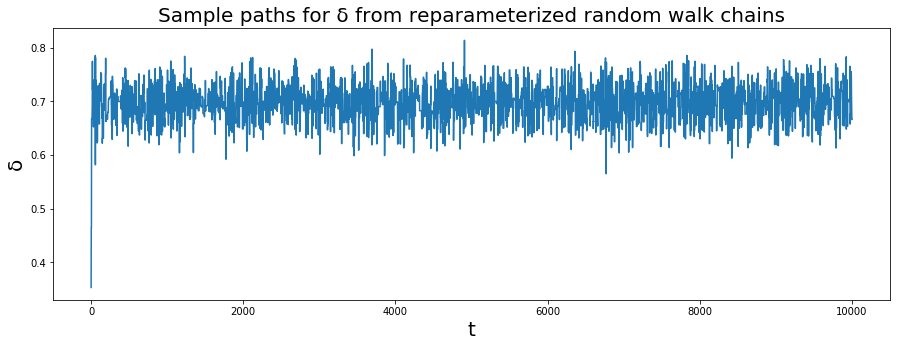

In [18]:
plt.figure(figsize=(15,5))
plt.plot(x,p)
plt.title('Sample paths for δ from reparameterized random walk chains',fontsize=20)
plt.xlabel('t',fontsize=20)
plt.ylabel('δ',fontsize=20)

# e)

### Table

In [19]:
results = [('Independance Chains',np.mean(v),np.std(v)),
           ('Random Walk Chains', np.mean(xt_chain),np.std(xt_chain)),
          ('Reparameterized Random Walk Chains',np.mean(p),np.std(p))]
print(tabulate(results, headers=["Method", "mean", "std"]))

Method                                  mean        std
----------------------------------  --------  ---------
Independance Chains                 0.701825  0.0313483
Random Walk Chains                  0.703225  0.0334197
Reparameterized Random Walk Chains  0.698507  0.0320682


The mean (estimated value) of all algorithms are close. From the variance We also see that random walk for $\delta$ estimation is poor and for reparametrized and independance chains we see better results. 

# 2

### Proposal distributions of $ N(0,0.01), N(7,0.01)$ and $N(15,0.01)$

In [20]:
def alpha(x,y):
    return min( 1, (.7*norm.pdf(y,7,.5)+.3*norm.pdf(y,10,.5))/(.7*norm.pdf(x,7,.5)+.3*norm.pdf(x,10,.5)))   

In [21]:
def N_metro(mu,sigma,nitr):
    r = np.zeros(nitr)
    x = mu
    for k in range (0,nitr):
        u = uniform.rvs(0,1,1)
        y = norm.rvs(x,sigma,1)
        if u < alpha(x,y):
            x = y
        else:
            x =  mu
        r[k] = x
    xaxis = np.linspace(5,11,200)
    plotf(r,xaxis,mu,sigma)
    return r, print('Estimated Mean = ',np.mean(r)), print('Estimated std = ',np.std(r))

### Plot Function

In [22]:
def plotf(r,xaxis,mu,sigma):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0,nitr,nitr),r)
    plt.title('Sample paths for δ',fontsize=15)
    plt.xlabel('t',fontsize=15)
    plt.ylabel('δ',fontsize=15)
    
    plt.subplot(2, 1, 2)
    sns.distplot(r, hist=True,bins=20,kde=False, color='green',hist_kws={'edgecolor':'black'},norm_hist=True)
    y = 0.7*norm.pdf(xaxis,7,0.5) +(0.3)*norm.pdf(xaxis,10,0.5)
    plt.plot(xaxis, y, 'k-')
    plt.title('Mixture of Normal Density',fontsize=15)
    plt.xlabel('y',fontsize=15)
    plt.ylabel('Density',fontsize=15)
    plt.show()

### For $N(0,0.01)$

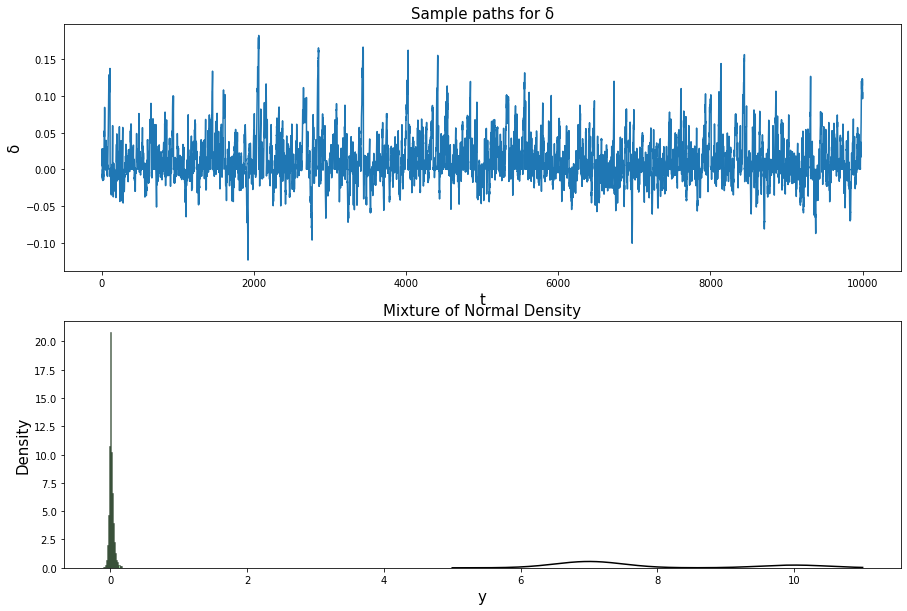

Estimated Mean =  0.013524496103243144
Estimated std =  0.03212960939288584


In [23]:
r = N_metro(mu[0],sigma[0],nitr)

### For $N(7,0.01)$

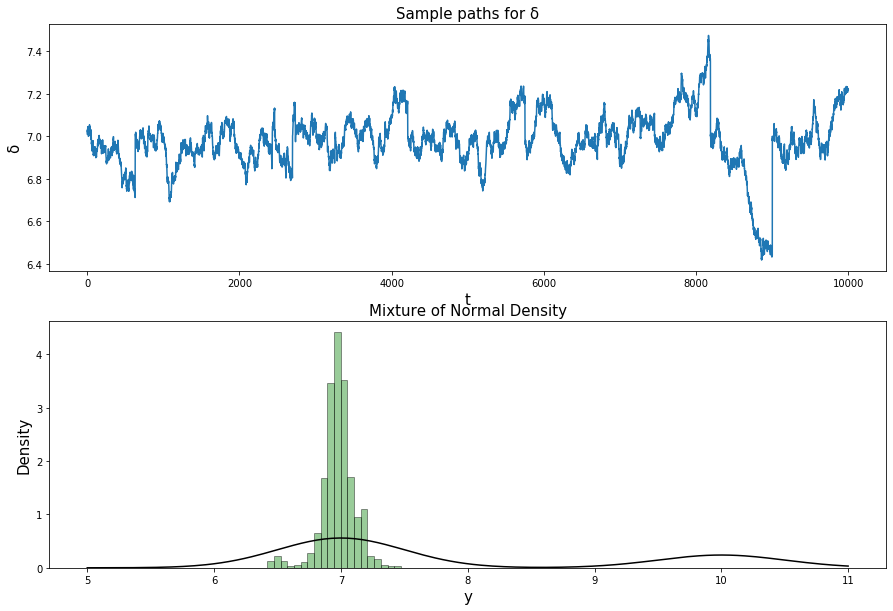

Estimated Mean =  6.97751369029589
Estimated std =  0.13240447485864382


In [24]:
r = N_metro(mu[1],sigma[0],nitr)

### For $N(15,0.01)$

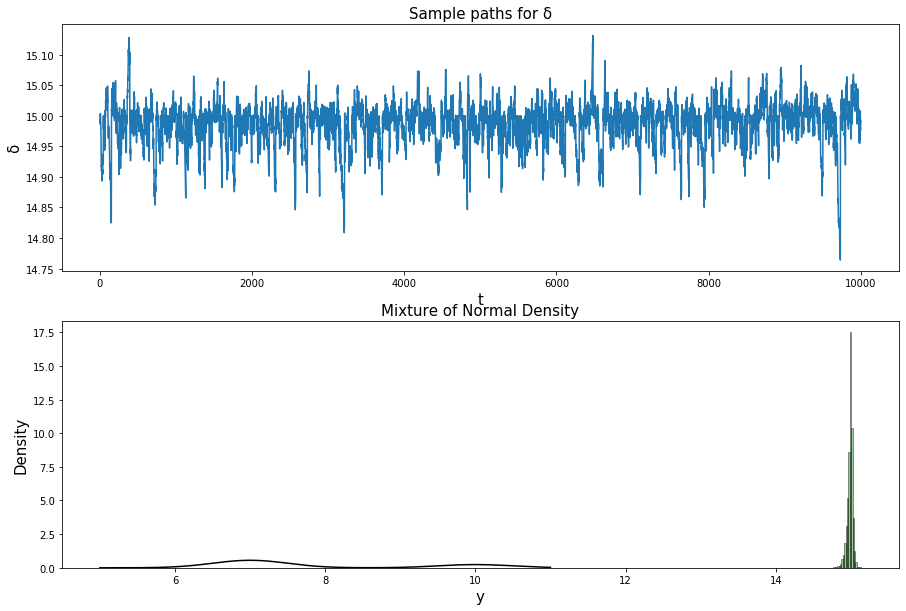

Estimated Mean =  14.985706602079746
Estimated std =  0.036285654262914926


In [25]:
r = N_metro(mu[3],sigma[0],nitr)

# b)

### Proposal distribution of  $N(0,1), N(7,1)$ and $N(15,1)$

### For $N(0,1)$

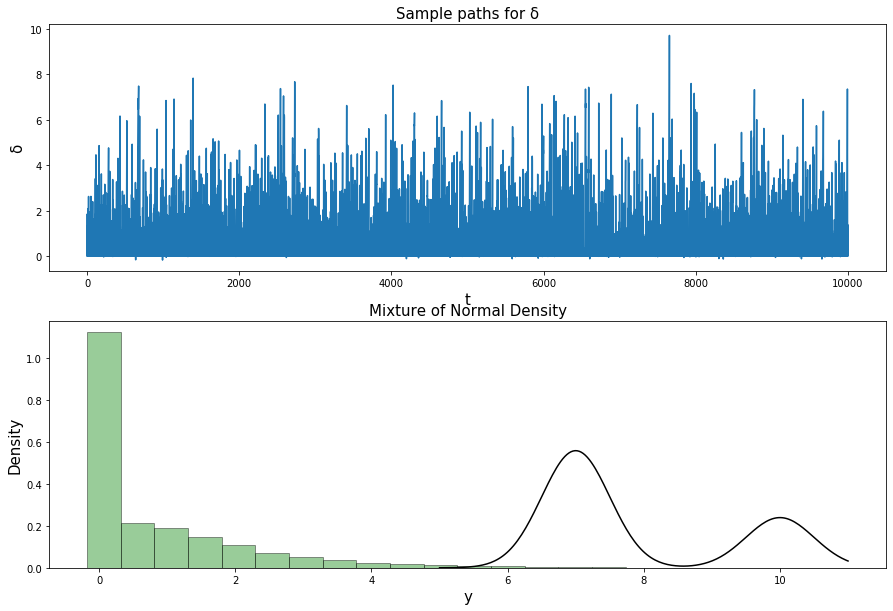

Estimated Mean =  0.8263435391416125
Estimated std =  1.272784340132953


In [26]:
r = N_metro(mu[0],sigma[2],nitr)

### For $N(7,1)$

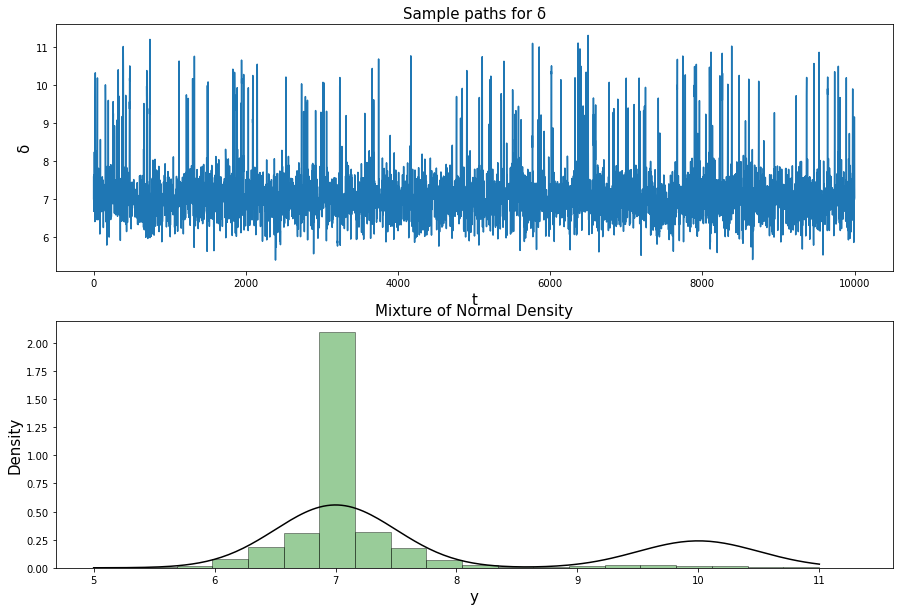

Estimated Mean =  7.0926522325297086
Estimated std =  0.5939278265279414


In [27]:
r = N_metro(mu[1],sigma[2],nitr)

### For $N(15,1)$

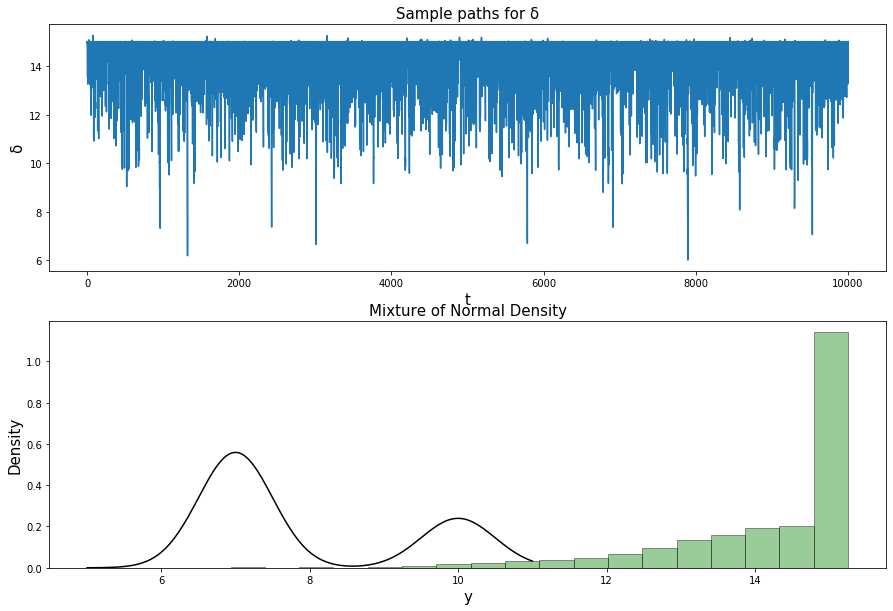

Estimated Mean =  14.145500375783449
Estimated std =  1.2757359712091372


In [28]:
r = N_metro(mu[3],sigma[2],nitr)